# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей
 
### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

**Обратите внимание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Описание данных
Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [3]:
users = pd.read_csv('/datasets/users.csv')

In [4]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
calls = pd.read_csv('/datasets/calls.csv')

In [7]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
messages = pd.read_csv('/datasets/messages.csv')

In [10]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
internet = pd.read_csv('/datasets/internet.csv')

In [13]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [15]:
tarrifs = pd.read_csv('/datasets/tariffs.csv')

In [16]:
tarrifs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
tarrifs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод

В данном шаге мы открыли файлы с данными, просмотрели их на предмет пропусков и типов данных. В следующем шаге будем исправлять проблемы, имеющиеся в данных.

### Шаг 2. Подготовьте данные

Исправим ошибки в формате данных.

В таблицах internet, messages, calls и users даты представлены в формате objects. Переведем их в формат datetime.

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format=('%Y-%m-%d'))
messages['message_date'] = pd.to_datetime(messages['message_date'], format=('%Y-%m-%d'))
calls['call_date'] = pd.to_datetime(calls['call_date'], format=('%Y-%m-%d'))
users['reg_date'] = pd.to_datetime(users['reg_date'], format=('%Y-%m-%d'))
users['churn_date'] = pd.to_datetime(users['churn_date'], format=('%Y-%m-%d'))

В таблице internet стоблец Unnamed: 0 полностью повторяет столбец id, поэтому его можно смело удалить.

In [19]:
internet.drop(['Unnamed: 0'], axis='columns', inplace=True)

Округлим вверх значения минут и мегабайтов, так как это одно из условий оператора «Мегалайн».

In [20]:
calls['duration_ceiled'] = calls['duration'].apply(np.ceil)
internet['mb_used_ceiled'] = internet['mb_used'].apply(np.ceil)

Теперь посмотрим на такую деталь как звонки с продолжительностью в 0 минут.
Выдвину предположение, что звонки с продолжительностью в 0 минут - это недозвоны. Если мы будем эти звонки брать в агрегацию с другими звонками, то можем получить искаженную картину, так как недозвоны бесплатные, соответственно человек может делать их сколько угодно много, не думая о том, что у него за это снимутся деньги. Поэтому, на мой взгляд, было бы логичней анализировать звонки, за которые взымается плата, то есть больше 0 секунд.

In [21]:
calls = calls[calls['duration'] != 0]

**Посчитаем для каждого пользователя:**

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;

Сначала выделим месяцы из дат во таблицах calls, messages и internet.

In [22]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Сделаем сводные таблицы для подсчета требуемых параметров.

In [23]:
month_calls = calls.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count').reset_index()
month_duration = calls.pivot_table(index = ['user_id','month'], values = 'duration_ceiled',  aggfunc = 'sum').reset_index()
month_messages = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count').reset_index()
month_internet = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used_ceiled', aggfunc = 'sum').reset_index()

In [24]:
month_calls.rename(columns={'id': 'number_of_calls'}, inplace=True)
month_messages.columns = ['user_id','month','messages']

In [25]:
month_calls

,user_id,month,number_of_calls
0,1000,5,17
1,1000,6,28
2,1000,7,41
3,1000,8,42
4,1000,9,46
...,...,...,...
3163,1498,10,30
3164,1499,9,8
3165,1499,10,44
3166,1499,11,62


In [26]:
month_duration

,user_id,month,duration_ceiled
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0
...,...,...,...
3163,1498,10,247.0
3164,1499,9,70.0
3165,1499,10,449.0
3166,1499,11,612.0


In [27]:
month_messages

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [28]:
month_internet

,user_id,month,mb_used_ceiled
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3198,1498,10,20604.0
3199,1499,9,1848.0
3200,1499,10,17809.0
3201,1499,11,17984.0


- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Сначала сделаем датафрейм, в который будем собираться информацию со всех таблиц, что мы посчитали выше.

Для этого сформируем первые данные, которые в нем будут. Это все имеющиеся id клиентов и для каждого id по 12 месяцев.

In [29]:
user_range = users['user_id'] 

In [30]:
month_range = range(1,13)

In [31]:
user_mth_index = pd.DataFrame(index=pd.MultiIndex.from_product([user_range,month_range])).reset_index() #формируем все в единый датафрейм

In [32]:
user_mth_index.columns = ['user_id','month']

In [33]:
user_mth_index

,user_id,month
0,1000,1
1,1000,2
2,1000,3
3,1000,4
4,1000,5
...,...,...
5995,1499,8
5996,1499,9
5997,1499,10
5998,1499,11


Собираем общую талбицу со всеми данными:

In [34]:
users_summary = user_mth_index.merge(month_calls, on = ['user_id','month'], how = 'left').\
merge(month_duration, on = ['user_id','month'], how = 'left').\
merge(month_messages, on = ['user_id','month'], how = 'left').\
merge(month_internet, on = ['user_id','month'], how = 'left')

In [35]:
users_summary.head(20)

,user_id,month,number_of_calls,duration_ceiled,messages,mb_used_ceiled
0,1000,1,NaN,NaN,NaN,NaN
1,1000,2,NaN,NaN,NaN,NaN
2,1000,3,NaN,NaN,NaN,NaN
3,1000,4,NaN,NaN,NaN,NaN
4,1000,5,17.0,159.0,22.0,2256.0
5,1000,6,28.0,172.0,60.0,23257.0
6,1000,7,41.0,340.0,75.0,14016.0
7,1000,8,42.0,408.0,81.0,14070.0
8,1000,9,46.0,466.0,57.0,14581.0
9,1000,10,44.0,350.0,73.0,14717.0


Теперь надо убрать из таблицы месяцы, когда пользователь еще не был клиентом либо уже перестал им быть. Для этого будем сравнивать месяцем регистрации(reg_month) и месяцем ухода пользователя(churn_month).

In [36]:
users['churn_month'] = users['churn_date'].dt.month
users['reg_month'] = users['reg_date'].dt.month

Присоединяем эти месяцы к таблице users_summary вместе с информацией для тарифа для каждого клиента.

In [37]:
users_summary = users_summary.merge(users[['user_id','churn_month','reg_month', 'tariff']], on = 'user_id', how = 'left')

In [38]:
users_summary = users_summary[(users_summary['month'] >= users_summary['reg_month'])]
users_summary = users_summary[(users_summary['month'] <= users_summary['churn_month']) | (users_summary['churn_month'].isnull())]

In [39]:
users_summary

,user_id,month,number_of_calls,duration_ceiled,messages,mb_used_ceiled,churn_month,reg_month,tariff
4,1000,5,17.0,159.0,22.0,2256.0,NaN,5,ultra
5,1000,6,28.0,172.0,60.0,23257.0,NaN,5,ultra
6,1000,7,41.0,340.0,75.0,14016.0,NaN,5,ultra
7,1000,8,42.0,408.0,81.0,14070.0,NaN,5,ultra
8,1000,9,46.0,466.0,57.0,14581.0,NaN,5,ultra
...,...,...,...,...,...,...,...,...,...
5985,1498,10,30.0,247.0,42.0,20604.0,10.0,7,smart
5996,1499,9,8.0,70.0,11.0,1848.0,NaN,9,smart
5997,1499,10,44.0,449.0,48.0,17809.0,NaN,9,smart
5998,1499,11,62.0,612.0,59.0,17984.0,NaN,9,smart


Напишем функции, которые считают разницу между общим количеством минут разговора, посланными сообщениями, потребленным интернет - трафиком и соответствующим им лимитам.

In [40]:
def delta_duration(data):
    if data['tariff'] == 'smart':
        if data['duration_ceiled'] - 500 > 0:
            return data['duration_ceiled'] - 500
        else: return 0
    else:
        if data['duration_ceiled'] - 3000 > 0:
            return data['duration_ceiled'] - 3000
        else: return 0 

In [41]:
def delta_messages(data):
    if data['tariff'] == 'smart':
        if data['messages'] - 50 > 0:
            return data['messages'] - 50
        else: return 0
    else:
        if data['messages'] - 1000 > 0:
            return data['messages'] - 1000
        else: return 0 

In [42]:
def delta_mb_used(data):
    if data['tariff'] == 'smart':
        if data['mb_used_ceiled']/1024 - 15 > 0:
            return np.ceil(data['mb_used_ceiled']/1024 - 15)
        else: return 0
    else:
        if data['mb_used_ceiled']/1024 - 30 > 0:
            return np.ceil(data['mb_used_ceiled']/1024 - 30)
        else: return 0 

Напишем функцию, которая считает общую выручку по клиенту.

In [43]:
def summary(data):
    if data['tariff'] == 'smart':
        return data['delta_duration']*3 + data['delta_messages']*3 + data['delta_mb_used']*200 + 550
    else: return data['delta_duration']*1 + data['delta_messages']*1 + data['delta_mb_used']*150 + 1950

Применим написанные функции к датафрейму users_summary.

In [44]:
users_summary['delta_duration'] = users_summary.apply(delta_duration, axis = 1)
users_summary['delta_messages'] = users_summary.apply(delta_messages, axis = 1)
users_summary['delta_mb_used'] = users_summary.apply(delta_mb_used, axis = 1)
users_summary['summary'] = users_summary.apply(summary, axis = 1)

In [45]:
users_summary

,user_id,month,number_of_calls,duration_ceiled,messages,mb_used_ceiled,churn_month,reg_month,tariff,delta_duration,delta_messages,delta_mb_used,summary
4,1000,5,17.0,159.0,22.0,2256.0,NaN,5,ultra,0.0,0.0,0.0,1950.0
5,1000,6,28.0,172.0,60.0,23257.0,NaN,5,ultra,0.0,0.0,0.0,1950.0
6,1000,7,41.0,340.0,75.0,14016.0,NaN,5,ultra,0.0,0.0,0.0,1950.0
7,1000,8,42.0,408.0,81.0,14070.0,NaN,5,ultra,0.0,0.0,0.0,1950.0
8,1000,9,46.0,466.0,57.0,14581.0,NaN,5,ultra,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,1498,10,30.0,247.0,42.0,20604.0,10.0,7,smart,0.0,0.0,6.0,1750.0
5996,1499,9,8.0,70.0,11.0,1848.0,NaN,9,smart,0.0,0.0,0.0,550.0
5997,1499,10,44.0,449.0,48.0,17809.0,NaN,9,smart,0.0,0.0,3.0,1150.0
5998,1499,11,62.0,612.0,59.0,17984.0,NaN,9,smart,112.0,9.0,3.0,1513.0


### Вывод: 

В данном шаге мы провели работу по агригации данных с целью найти выручку по каждому пользователю за каждый месяц пользования услугами оператора "Мегалайн". В результате был сформирован датафрейм, где для каждого пользователя в конкретный месяц имеется информация о количестве израсходованных минут разговора, переданных сообщений, потребленного интернет-трафика, превышение лимита по каждому из этих показателей, а также выручка, полученная с клиента. 

### Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Посмотрим на показатели для тарифа "Смарт":

In [46]:
users_smart = users_summary[users_summary['tariff'] == 'smart']

Средние значения по количеству минут разговора, сообщениям и интернет-трафику каждого месяца пользователя тарифа "Смарт":

In [47]:
users_smart.pivot_table(index = 'month', values = ['duration_ceiled', 'messages', 'mb_used_ceiled'], aggfunc = 'mean')

,duration_ceiled,mb_used_ceiled,messages
month,,,
1,210.030303,8524.441176,20.000000
2,298.689655,11611.396552,27.940000
3,390.051948,15123.857143,35.550725
4,370.441441,13479.482143,35.864583
5,387.361702,15825.198582,39.032787
6,398.067485,15814.768293,38.577465
7,408.353234,15763.512438,38.988506
8,423.269231,16703.252137,38.750000
9,430.266409,16324.526923,39.219731


In [48]:
print('Среднее количество минут, требующееся пользователю тарифа "Смарт" в месяц -', users_smart['duration_ceiled'].mean())
print('Среднее количество сообщений, который отправляет пользователь тарифа "Смарт" в месяц -', users_smart['messages'].mean())
print('Среднее количество гигабайт трафика, требующееся пользователю тарифа "Смарт" в месяц -', ((users_smart['mb_used_ceiled'])/1024).mean())

Среднее количество минут, требующееся пользователю тарифа "Смарт" в месяц - 419.4403421882035
Среднее количество сообщений, который отправляет пользователь тарифа "Смарт" в месяц - 38.71644120707596
Среднее количество гигабайт трафика, требующееся пользователю тарифа "Смарт" в месяц - 15.855930294125898


In [49]:
print('Дисперсия количества минут разговора в месяц пользователей тарифа "Смарт"', np.var(users_smart['duration_ceiled']))
print('Дисперсия количества сообщений в месяц пользователей тарифа "Смарт"', np.var(users_smart['messages']))
print('Дисперсия количества гигабайт трафика в месяц пользователей тарифа "Смарт"', np.var((users_smart['mb_used_ceiled'])/1024))


Дисперсия количества минут разговора в месяц пользователей тарифа "Смарт" 35702.046530995016
Дисперсия количества сообщений в месяц пользователей тарифа "Смарт" 717.220843110227
Дисперсия количества гигабайт трафика в месяц пользователей тарифа "Смарт" 32.83275745387133


In [50]:
print('Стандартное отклонение количества минут разговора в месяц пользователей тарифа "Смарт"', np.std(users_smart['duration_ceiled']))
print('Стандартное отклонение сообщений в месяц пользователей тарифа "Смарт"', np.std(users_smart['messages']))
print('Стандартное отклонение гигабайт трафика в месяц пользователей тарифа "Смарт"', np.std((users_smart['mb_used_ceiled'])/1024))


Стандартное отклонение количества минут разговора в месяц пользователей тарифа "Смарт" 188.9498518946099
Стандартное отклонение сообщений в месяц пользователей тарифа "Смарт" 26.780979129042816
Стандартное отклонение гигабайт трафика в месяц пользователей тарифа "Смарт" 5.729987561406336


По этим данным можно сказать, что пользователям тарифа "Смарт" в среднем хватает лимита на разговоры и сообщения, но объем интернет-трафика выходит за лимит почти на 1 гигабайт.

Тариф "Ультра":

In [51]:
users_ultra = users_summary[users_summary['tariff'] == 'ultra']

Средние значения по количеству минут разговора, сообщениям и интернет-трафику каждого месяца пользователя тарифа "Ультра":

In [52]:
users_ultra.pivot_table(index = 'month', values = ['duration_ceiled', 'messages', 'mb_used_ceiled'], aggfunc = 'mean')

,duration_ceiled,mb_used_ceiled,messages
month,,,
1,428.111111,13153.555556,43.428571
2,310.043478,12858.500000,32.937500
3,489.648649,17551.972973,47.800000
4,475.301887,16843.800000,44.512821
5,534.250000,19674.848485,48.769231
6,497.469136,19170.457831,52.313433
7,570.885057,20742.588889,62.136986
8,535.813725,19778.915094,58.897727
9,563.963636,19390.824561,63.294737


In [53]:
print('Среднее количество минут, требующееся пользователю тарифа "Ультра" в месяц -', users_ultra['duration_ceiled'].mean())
print('Среднее количество сообщений, который отправляет пользователь тарифа "Ультра" в месяц -', users_ultra['messages'].mean())
print('Среднее количество гигабайт трафика, требующееся пользователю тарифа "Ультра" в месяц -', ((users_ultra['mb_used_ceiled'])/1024).mean())

Среднее количество минут, требующееся пользователю тарифа "Ультра" в месяц - 547.7550158394931
Среднее количество сообщений, который отправляет пользователь тарифа "Ультра" в месяц - 61.161006289308176
Среднее количество гигабайт трафика, требующееся пользователю тарифа "Ультра" в месяц - 19.225358573717948


In [54]:
print('Дисперсия количества минут разговора в месяц пользователей тарифа "Ультра"', np.var(users_ultra['duration_ceiled']))
print('Дисперсия количества сообщений в месяц пользователей тарифа "Ультра"', np.var(users_ultra['messages']))
print('Дисперсия количества гигабайт трафика в месяц пользователей тарифа "Ультра"', np.var((users_ultra['mb_used_ceiled'])/1024))


Дисперсия количества минут разговора в месяц пользователей тарифа "Ультра" 93239.86606512648
Дисперсия количества сообщений в месяц пользователей тарифа "Ультра" 2107.0055235156838
Дисперсия количества гигабайт трафика в месяц пользователей тарифа "Ультра" 94.35830745026979


In [55]:
print('Стандартное отклонение количества минут разговора в месяц пользователей тарифа "Ультра"', np.std(users_ultra['duration_ceiled']))
print('Стандартное отклонение сообщений в месяц пользователей тарифа "Ультра"', np.std(users_ultra['messages']))
print('Стандартное отклонение гигабайт трафика в месяц пользователей тарифа "Ультра"', np.std((users_ultra['mb_used_ceiled'])/1024))


Стандартное отклонение количества минут разговора в месяц пользователей тарифа "Ультра" 305.35203628783364
Стандартное отклонение сообщений в месяц пользователей тарифа "Ультра" 45.90212983637779
Стандартное отклонение гигабайт трафика в месяц пользователей тарифа "Ультра" 9.713820435352394


По этим данным можно сказать, в среднем такой большой лимит на минуты разговора и сообщения не потребляется клиентами тарифа "Ультра". Также расход интернет - трафика находится далеко от лимита.

Теперь построим гистограммы распределения количества минут разговора, сообщений и интернет-трафика для каждого тарифа.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


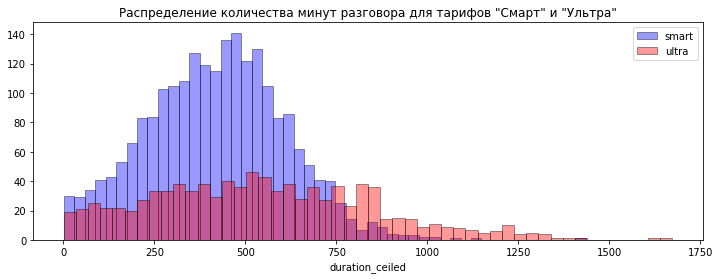

In [56]:
plt.figure(figsize = (12,4))
plt.title('Распределение количества минут разговора для тарифов "Смарт" и "Ультра"')
sns.distplot(users_smart['duration_ceiled'], hist=True, kde=False, 
             bins=50, color = 'blue',
             label = 'smart',
             hist_kws={'edgecolor':'black'})
sns.distplot(users_ultra['duration_ceiled'], hist=True, kde=False, 
             bins=50, color = 'red',
             label = 'ultra',
             hist_kws={'edgecolor':'black'})
plt.legend()

Распределение для тарифа "Смарт" напоминает нормальное, с пиком в районе 500 минут. Для тарифа "Ультра" нельзя подобрать четкий вид распределения, начиная от 250 и до 750 минут можно видеть примерно одинаковый уровень потраченных минут. Правый конец распределения для тарифа "Ультра" намного длинее конца "Смарт", то есть больших значений у него больше, что довольно логично.

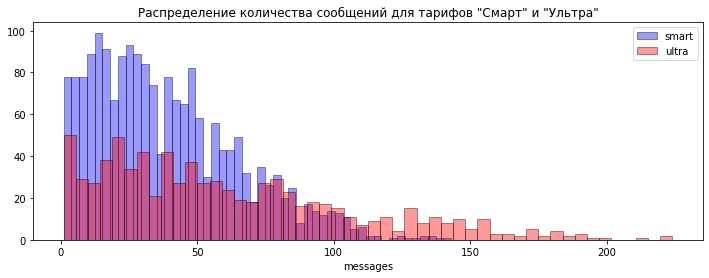

In [57]:
plt.figure(figsize = (12,4))
plt.title('Распределение количества сообщений для тарифов "Смарт" и "Ультра"')
sns.distplot(users_smart['messages'], hist=True, kde=False, 
             bins=50, color = 'blue',
             label = 'smart',
             hist_kws={'edgecolor':'black'})
sns.distplot(users_ultra['messages'], hist=True, kde=False, 
             bins=50, color = 'red',
             label = 'ultra',
             hist_kws={'edgecolor':'black'})
plt.legend()

Дать точное определение для распределения данных величин я не могу, но у них есть свои особенности. Пик у них находится в начале, затем идет плавное уменьшение, что говорит о том, что если сообщениями и пользуются, то совсем не часто, большинство пользователей предпочитает другие способы связи.

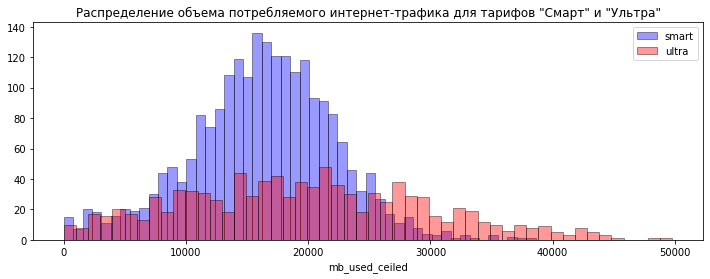

In [58]:
plt.figure(figsize = (12,4))
plt.title('Распределение объема потребляемого интернет-трафика для тарифов "Смарт" и "Ультра"')
sns.distplot(users_smart['mb_used_ceiled'], hist=True, kde=False, 
             bins=50, color = 'blue',
             label = 'smart',
             hist_kws={'edgecolor':'black'})
sns.distplot(users_ultra['mb_used_ceiled'], hist=True, kde=False, 
             bins=50, color = 'red',
             label = 'ultra',
             hist_kws={'edgecolor':'black'})
plt.legend()

Распреление для тарифа "Смарт" похоже на нормальное с пиком в районе 16000 мб. Для тарифа "Ультра" тоже можно сделать предположение, что его распределение похоже на нормальное, но с бОльшими оговорками. У него есть пик в районе 22000 мб, есть нисходящий тренд в обе стороны от пика, однако не совсем ровный. Правый конец этого распределения опять длинее, чем у тарифа "Смарт", что объясняется бОльшей вариативностью его значений.

### Вывод

В данном шаге мы изучили поведение клиентов оператора "Мегалайн", исходя из того, какой тариф они имеют. Для тарифа "Смарт" можно сделать вывод, что в среднем люди не выходят за пределы лимита по количеству минут для разговора и переданным сообщениям, но интернет - трафик потребляют в среднем на 0.85 ГБ больше лимита. Пользователи тарифа "Ультра" в среднем находятся довольно далеко от лимитов по всем трем параметрам. Что касается распределения основных параметров, то можно сказать, что в основном распределения параметров для двух тарифов имеют одинаковый вид, но хвост длинее у распределения "Ультра" засчет бОльшей вариативности данных (так как у него больше лимиты).

### Шаг 4. Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

Сформулируем нулевую гипотезу: выручка пользователей тарифов "Ультра" и "Смарт" не различается. Альтернативная гипотеза - средние выручки различаются.

Для того, чтобы опровергнуть нулевую гипотезу или не опровергнуть ее, воспользуемся scipy.stats.ttest_ind. Мы используем этот метод потому что есть две выборки из двух генеральных совокупностей.

In [59]:
users_smart

,user_id,month,number_of_calls,duration_ceiled,messages,mb_used_ceiled,churn_month,reg_month,tariff,delta_duration,delta_messages,delta_mb_used,summary
22,1001,11,45.0,430.0,NaN,18452.0,NaN,11,smart,0.0,0.0,4.0,1350.0
23,1001,12,47.0,414.0,NaN,14053.0,NaN,11,smart,0.0,0.0,0.0,550.0
29,1002,6,14.0,117.0,4.0,10871.0,NaN,6,smart,0.0,0.0,0.0,550.0
30,1002,7,21.0,214.0,11.0,17601.0,NaN,6,smart,0.0,0.0,3.0,1150.0
31,1002,8,37.0,289.0,13.0,20347.0,NaN,6,smart,0.0,0.0,5.0,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,1498,10,30.0,247.0,42.0,20604.0,10.0,7,smart,0.0,0.0,6.0,1750.0
5996,1499,9,8.0,70.0,11.0,1848.0,NaN,9,smart,0.0,0.0,0.0,550.0
5997,1499,10,44.0,449.0,48.0,17809.0,NaN,9,smart,0.0,0.0,3.0,1150.0
5998,1499,11,62.0,612.0,59.0,17984.0,NaN,9,smart,112.0,9.0,3.0,1513.0


In [60]:
smart_summary = users_smart['summary'].tolist() #выборка из выручек пользователей тарифа смарт
ultra_summary = users_ultra['summary'].tolist() #выборка из выручек пользователей тарифа ультра

In [61]:
alpha = .05

In [62]:
np.var(users_smart['summary']) 

673575.4363387561

In [63]:
np.var(users_ultra['summary'])

143215.03328546917

Дисперсии отличаются более чем в 4 раза, поэтому их нельзя признать равными, поэтому параметр equal_var = False.

In [64]:
results = st.ttest_ind(
    smart_summary, 
    ultra_summary,
    equal_var = False)

In [65]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2414049931248708e-246
Отвергаем нулевую гипотезу


По полученным результатам можно сделать вывод, что при условии, что нулевая гипотеза верна, получить наблюдаемый или ещё более далёкий от предполагаемого результат можно с вероятностью 1.2414049931248708e-246. Это вероятность сильно меньше 0.05, поэтому смело отвергаем нулевую гипотезу.

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Для того, чтобы проверить эту гипотезу, нужно присоединить стоблец с городами.

In [66]:
users_summary = users_summary.merge(users[['user_id', 'city']], on = 'user_id', how = 'left')

Сформируем две подвыборки, которые делят общую выборку на жителей Москвы и других городов.

In [67]:
moscow_users = users_summary[users_summary['city'] == 'Москва']
not_moscow_users = users_summary[users_summary['city'] != 'Москва']

Выберем только столбец с выручкой и переведем его в список.

In [69]:
moscow_users_summary = moscow_users['summary'].tolist()
not_moscow_users_summary = not_moscow_users['summary'].tolist()

Сформулируем нулевую гипотезу: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для того, чтобы опровергнуть нулевую гипотезу или не опровергнуть ее, воспользуемся scipy.stats.ttest_ind. Мы используем этот метод потому что есть две выборки из двух генеральных совокупностей.

In [ ]:
np.var(moscow_users['summary']) 

In [ ]:
np.var(not_moscow_users['summary']) 

Дисперсии отличаются несильно, поэтому можем принять параметр equal_var = True

In [ ]:
results = st.ttest_ind(
    moscow_users_summary, 
    not_moscow_users_summary,
    equal_var = True)

In [ ]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

По полученным результатам можно сделать вывод, что при условии, что нулевая гипотеза верна, получить наблюдаемый или ещё более далёкий от предполагаемого результат можно с вероятностью 0.5277299573181309. Это вероятность выше 0.05, поэтому у нас нет оснований отвергнуть нулевую гипотезу.

### Вывод

Мы проверили гипотезы о том, равны ли средние выручки клиентов тарифов "Смарт" и "Ультра" и равны ли средние выручки клиентов из Москвы и других регионов. В результате получили, что мы не можем утверждать, что выручки клиентов двух тарифов равны. Также проделанные нами вычисления не дают права отвергнуть гиоптезу о том, что выручки клиентов из Москвы и других регионов равны.

### Шаг 5. Напишите общий вывод

В данной работе был произведен анализ выборки оператора "Мегалайн". На основе имеющихся данных, для каждого клиента было подсчитано его помесячное потребление основных параметров(разговорных минут, отправленных сообщений, интернет-трафика), переход за лимит этих параметров и выручка. Затем была проанализирована выборка в разрезе тарифов пользователей. Выяснилось, что в среднем потребление по всем параметрам у тарифа "Ультра" больше, чем у тарифа "Смарт"(что логично, ведь этот тариф дороже и лимит по нему шире). Что касается распределения основных параметров для двух тарифов, то в целом они похожи друг на друга, только засчет больших лимитов, тариф "Ультра" имеет более длинные хвосты распределений. В заключительном шаге были проверены две гипотезы о равенстве выручки двух тарифов и равенстве выручки клиентов из Москвы и из других регионов. В первом случае оказалось, что мы должны отвергнуть нулевую гипотезу, говорящую о том, что выручки клиентов тарифов "Смарт" и "Ультра" равны. Во втором случае у нас не было оснований отвергнуть гипотезу о том, что выручка клиентов из Москвы равна выручке клиентов из других регионов. Тяжело сделать вывод о том, какой тариф лучше, так как нет четкой метрики для того, чтобы это понять. Можно сказать, что тариф "Ультра" лучше, потому что денег за него оператор получает больше, чем со "Смарта", при этом лимиты тарифа "Ультра" расходуются далеко не полностью, в отличие от тарифа "Смарт". То есть, люди могли бы чуть урезать свое потребление и перейти на "Смарт", но остаются на "Ультра" и тратят почти в 3.5 раза больше.